In [2]:
from __future__ import division


from pylab import *
#import random_idx
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})


In [3]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27, ares=20000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [4]:
def p_hit(M, N=10000, D=27, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(reject_thresh * N, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

def p_corr_rej(M, N=10000, reject_thresh=0.5, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N * reject_thresh, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [5]:
def cconv(a, b):
    return real(ifft(fft(a) * fft(b)))
    
def ccinv(a):
    return real(ifft(np.conj(fft(a))))

In [6]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

## Sparse Hopfield net decoding



/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


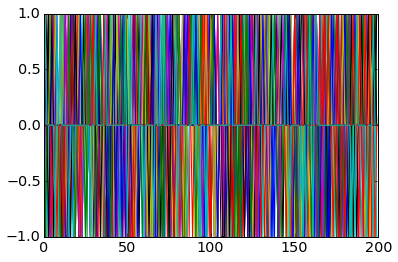

In [60]:
N = 200
D = 32
sf = 0.9
Ks = 2*round(N*(1-sf))

letter_vectors = np.zeros((D,N))

for d in range(D):
    ip = np.random.choice(N, size=Ks, replace=False)
    letter_vectors[d, ip[:Ks//2]] = 1
    letter_vectors[d, ip[Ks//2:]] = -1
    
#letter_vectors = 2 * (np.random.randn(D,N) < 0) - 1
#letter_vectors[np.random.rand(D,N) < sf] = 0

plot(letter_vectors.T);

In [61]:
Ks


40.0

In [62]:
Ms = 100
lidx = np.random.randint(D, size=Ms)

LVs = np.zeros((D, N, N))

for d in range(D):
    LVs[d, :,:] = np.outer(letter_vectors[d, :], letter_vectors[d, :])

In [63]:
psi = np.zeros(N)
big_psi = np.zeros((N,N))

for il, let in enumerate(lidx):
    psi += np.roll(letter_vectors[let, :], il)
    
    big_psi += np.roll(np.roll(LVs[let, :,:], il, axis=0), il, axis=1)
    


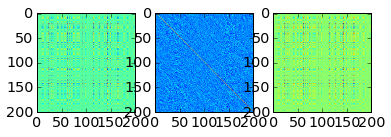

In [64]:
psi_outer = np.outer(psi, psi)

subplot(131)
imshow(psi_outer)

subplot(132)
imshow(big_psi)

subplot(133)
imshow(big_psi - psi_outer)

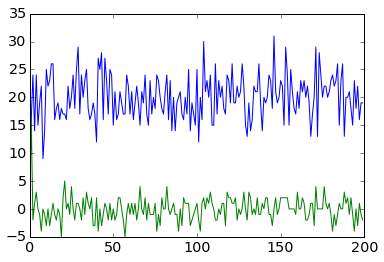

In [65]:
plot(diag(big_psi))

plot(big_psi[:, 1])

In [66]:
np.fill_diagonal(big_psi, 0)

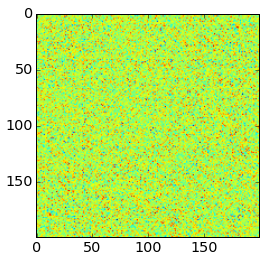

In [67]:
imshow(big_psi)

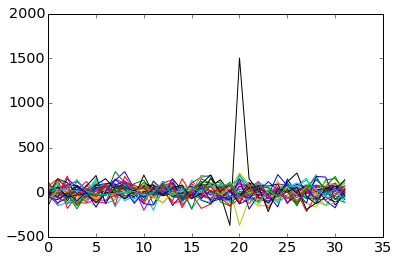

In [68]:
decode_address = 2
decode_vecs =np.roll(letter_vectors, decode_address, axis=1).T
psi_step = np.dot(big_psi, decode_vecs)

plot(np.dot(decode_vecs.T, psi_step))

In [69]:
vv = np.argpartition(np.abs(psi_step), Ks, axis=0)

ss = np.zeros_like(psi_step)

for i in range(psi_step.shape[1]):
    
    vv = np.argpartition(-np.abs(psi_step[:, i]), Ks)
    ss[vv[:Ks], i] = np.sign(psi_step[vv[:Ks], i])


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [70]:
psi_step[vv[:Ks], i]

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


array([ 18., -30., -17.,  20.,  24.,  21.,  20., -20.,  22.,  17., -21.,
        19.,  17., -22.,  20., -24.,  26.,  27.,  20.,  17., -18., -20.,
       -21., -17.,  28.,  24.,  19., -23.,  22., -20., -17., -23.,  18.,
       -16., -15.,  15.,  16., -15.,  16., -14.])

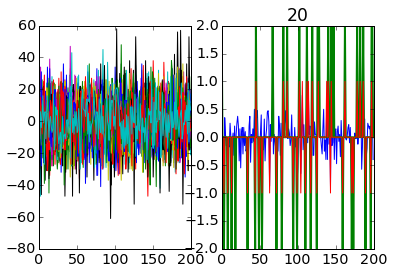

In [71]:
subplot(121)
plot(psi_step);
subplot(122)
plot(psi_step[:,lidx[decode_address]]/Ks);

plot(2*decode_vecs[:, lidx[decode_address]], lw=2)
plot(ss[:, lidx[decode_address]])

title(lidx[decode_address])

In [72]:
nsteps = 10
hop_hist = np.zeros((N, D, nsteps))
decode_address = 16

decode_vecs = np.roll(letter_vectors, decode_address, axis=1).T
psi_step = decode_vecs.copy()


for istep in range(nsteps):
    hop_hist[:, :, istep] = psi_step
    
    psi_step = np.dot(big_psi, psi_step)
    ss = np.zeros_like(psi_step)

    for i in range(psi_step.shape[1]):
        vp = np.argpartition(-psi_step[:, i], Ks//2)
        vn = np.argpartition(psi_step[:,i], Ks//2)
                
        ss[vp[:Ks//2], i] = 1.0
        ss[vn[:Ks//2], i] = -1.0

    psi_step = ss


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [54]:
nsteps = 10
hop_hist = np.zeros((N, D, nsteps))
decode_address = 16

decode_vecs = np.roll(letter_vectors, decode_address, axis=1).T
psi_step = decode_vecs.copy()


for istep in range(nsteps):
    hop_hist[:, :, istep] = psi_step
    
    psi_step = np.dot(big_psi, psi_step)
    ss = np.zeros_like(psi_step)

    for i in range(psi_step.shape[1]):
        vv = np.argpartition(-np.abs(psi_step[:, i]), Ks)
        ss[vv[:Ks], i] = np.sign(psi_step[vv[:Ks], i])

    psi_step = ss


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


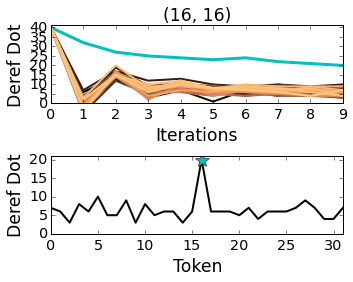

In [75]:
decode_dots = np.zeros((D, nsteps))
for istep in range(nsteps):
    for d in range(D):
        decode_dots[d, istep] = np.dot(hop_hist[:,d,istep].T, decode_vecs[:,d])

figure(figsize=(5,4))


cols = get_cmap('copper', D)
subplot(211)

for d in range(D):
    if d == lidx[decode_address]:
        plot(decode_dots[d, :], 'c', lw=3)
    else:
        plot(decode_dots[d, :], c=cols(d), lw=2)

ylim([0,41])
title((np.argmax(decode_dots[:,-1]), lidx[decode_address]))
xlabel('Iterations')
ylabel('Deref Dot')


subplot(212)
plot(decode_dots[:,-1], 'k', lw=2)
plot(lidx[decode_address], decode_dots[lidx[decode_address], -1], '*c', ms=15)
xlabel('Token')
ylabel('Deref Dot')
xlim([0, D-1])
ylim([0,21])

plt.tight_layout()

In [35]:
def test_sparse_hopfield_memory(M, N=100, D=32, K=5):
    
    Ks = 2*(K//2)

    # Create the representations
    letter_vectors = np.zeros((D,N))
    for d in range(D):
        ip = np.random.choice(N, size=Ks, replace=False)
        letter_vectors[d, ip[:Ks//2]] = 1
        letter_vectors[d, ip[Ks//2:]] = -1

    LVs = np.zeros((D, N, N))

    for d in range(D):
        LVs[d, :,:] = np.dot(letter_vectors[d:(d+1), :].T, letter_vectors[d:(d+1), :])

    # encode the letter sequence in the synapses
    lidx = np.random.randint(D, size=M)
    big_psi = np.zeros((N,N))

    for il, let in enumerate(lidx):
        big_psi += np.roll(np.roll(LVs[let, :,:], il, axis=0), il, axis=1)

        
    np.fill_diagonal(big_psi, 0)
    
    lidx_decode = np.zeros_like(lidx)
    
    # decode the letter sequence from the synapses
    for il, let in enumerate(lidx):
        
        nsteps = 1

        decode_vecs = np.roll(letter_vectors, il, axis=1).T
        psi_step = decode_vecs.copy()
        
        ss = np.zeros_like(psi_step)

        for istep in range(nsteps):
            psi_step = np.dot(big_psi, psi_step)

            for i in range(psi_step.shape[1]):

                vp = np.argpartition(-psi_step[:, i], Ks//2)
                vn = np.argpartition(psi_step[:,i], Ks//2)
                
                ss[vp[:Ks//2], i] = 1.0
                ss[vn[:Ks//2], i] = -1.0

            psi_step = ss
            
        lidx_decode[il] = np.argmax(np.diag(np.dot(psi_step.T, decode_vecs)))

    return lidx, lidx_decode

Elapsed:  19.0865750313


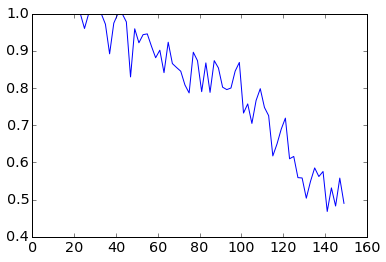

In [22]:
N = 80
test_M = np.arange(1, 150, 2)
D = 32

pc = np.zeros_like(test_M)
tst = time.time()

for im, M in enumerate(test_M):

    lidx, lidx_decode = test_sparse_hopfield_memory(M)
    
    pc[im] = np.sum(lidx==lidx_decode)

print 'Elapsed: ', time.time() - tst
plot(test_M, pc / test_M)

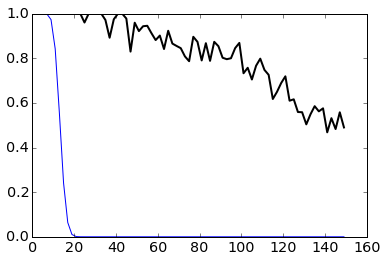

In [23]:
plot(test_M, pc / test_M, 'k', lw=2)
plot(test_M, p_correct_l(test_M, N=(N+1)*N/20, D=D)**M)

In [39]:
test_N = np.array([80, 160, 320, 640])
test_M = np.arange(1, 1020, 5)
test_D = np.array([32])
test_K = np.array([20])

num_correct = np.zeros((len(test_M), len(test_N), len(test_D), len(test_K)))

for iK, K in enumerate(test_K):
    for iN, N in enumerate(test_N):
        for iD, D in enumerate(test_D):
            tst = time.time()
            for im, M in enumerate(test_M):

                lidx, lidx_decode = test_sparse_hopfield_memory(M, N=N, D=D, K=K)

                num_correct[im, iN, iD, iK] = np.sum(lidx==lidx_decode)

            print 'N=', N, 'M=', M, 'D=', D, 'Elapsed: ', time.time() - tst

filename = ('data/sparse_hopfield_memory-Nx=' + str(test_N.max())
            + '-Mx' + str(test_M.max())
            + '-Dx' + str(test_D.max())
            + '-' + time.strftime('%y%m%d') +'.npz')
print filename
np.savez(filename, test_N=test_N, test_M=test_M, test_D=test_D, test_K=test_K, num_correct=num_correct)
            
            

N= 80 M= 1016 D= 32 Elapsed:  46.5101690292
N= 160 M= 1016 D= 32 Elapsed:  68.5403299332
N= 320 M= 1016 D= 32 Elapsed:  138.087347031
N= 640 M= 1016 D= 32 Elapsed:  423.674720049
data/sparse_hopfield_memory-Nx=640-Mx1016-Dx32-170128.npz


In [124]:
iD = 0
iK = -1

cols = get_cmap('jet', len(test_N))

for iN, N in enumerate(test_N):
    plot(test_M, num_correct[:, iN, iD, iK] / test_M, c=cols(iN), lw=2)
    plot(test_M, p_correct_l(test_M, N=0.5*test_N[iN]**1.5, D=test_D[iD]), c=cols(iN))
    
ylim([0,1.05])

xlabel('Number of tokens stored (M)')
ylabel('Accuracy')

filename = ('figures/sparse_hopfield_capacity-Nx=' + str(test_N.max())
            + '-Mx' + str(test_M.max())
            + '-Dx' + str(test_D.max())
            + '-Kx' + str(test_K.max())
            + '-' + time.strftime('%y%m%d') +'.npz')
print filename

savefig(filename + '.eps', format='eps', transparent=True)
savefig(filename + '.png', format='png', transparent=True)



IndexError: too many indices for array

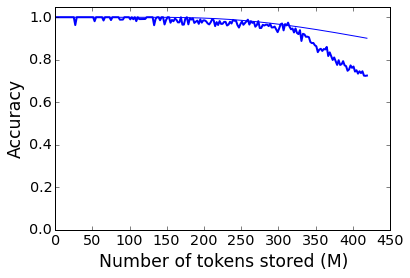

In [31]:
iN = -1
iK = -1

cols = get_cmap('winter', len(test_N))

for iD, D in enumerate(test_D):
    plot(test_M, num_correct[:, iN, iD, iK] / test_M, c=cols(iD), lw=2)
    plot(test_M, p_correct_l(test_M, N=0.05*test_N[iN]**2, D=test_D[iD]), c=cols(iD))
    
ylim([0,1.05])

xlabel('Number of tokens stored (M)')
ylabel('Accuracy')

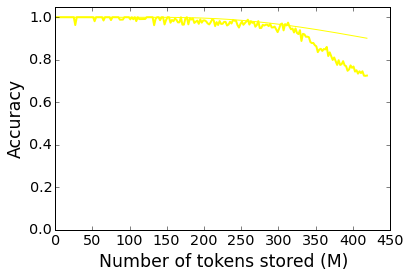

In [32]:
iN = -1
iD = -1

cols = get_cmap('spring', len(test_K))

for iK, K in enumerate(test_K):
    plot(test_M, num_correct[:, iN, iD, iK] / test_M, c=cols(iK), lw=2)
    plot(test_M, p_correct_l(test_M, N=0.05*test_N[iN]**2, D=test_D[iD]), c=cols(iK))
    
ylim([0,1.05])

xlabel('Number of tokens stored (M)')
ylabel('Accuracy')

## Key-Value Outerproduct


In [105]:

N=200
D=32
M=200

key_words = 2.0*(np.random.randn(M, N) < 0) - 1
value_words = 2.0*(np.random.randn(D, N) < 0) - 1

lidx = np.random.randint(D, size=M)

mem_matrix = np.zeros((N, N))

for i in range(M):
    mem_matrix += np.dot(key_words[i:(i+1), :].T, value_words[lidx[i]:(lidx[i]+1), :])



In [166]:
lidx

array([178, 115,  14, ...,  13, 164, 199])

In [106]:

decode_dist = np.zeros((M, D))

for i in range(M):
    decode_dist[i, :] = np.dot(value_words, np.dot(key_words[i, :], mem_matrix))
    

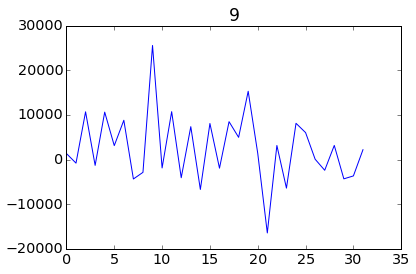

In [107]:
m = 2
plot(decode_dist[m,:])
title(lidx[m])

In [108]:
decode_lidx = np.argmax(decode_dist, axis=1)

In [109]:
np.sum(decode_lidx == lidx)

197

In [111]:
def test_outerproduct_memory(M, N=100, D=32):
    
    key_words = 2.0*(np.random.randn(M, N) < 0) - 1
    value_words = 2.0*(np.random.randn(D, N) < 0) - 1

    lidx = np.random.randint(D, size=M)

    mem_matrix = np.zeros((N, N))

    for i in range(M):
        mem_matrix += np.dot(key_words[i:(i+1), :].T, value_words[lidx[i]:(lidx[i]+1), :])

     
    decode_dist = np.zeros((M, D))

    for i in range(M):
        decode_dist[i, :] = np.dot(value_words, np.dot(key_words[i, :], mem_matrix))

    lidx_decode = np.argmax(decode_dist, axis=1)
    
    return lidx, lidx_decode
    

In [ ]:
def test_outerproduct_memory_roll(M, N=100, D=32):
    
    key_words = 2.0*(np.random.randn(M, N) < 0) - 1
    value_words = 2.0*(np.random.randn(D, N) < 0) - 1

    lidx = np.random.randint(D, size=M)

    mem_matrix = np.zeros((N, N))

    for i in range(M):
        mem_matrix += np.dot(key_words[i:(i+1), :].T, np.roll(value_words[lidx[i]:(lidx[i]+1), :], i))

     
    decode_dist = np.zeros((M, D))

    for i in range(M):
        decode_dist[i, :] = np.dot(np.roll(value_words, i), np.dot(key_words[i, :], mem_matrix))

    lidx_decode = np.argmax(decode_dist, axis=1)
    
    return lidx, lidx_decode
    

In [182]:
test_N = np.array([40, 80, 160, 320])
test_M = np.arange(1, 820, 10)
test_D = np.array([4, 32, 256])

num_correct = np.zeros((len(test_M), len(test_N), len(test_D)))

for iN, N in enumerate(test_N):
    for iD, D in enumerate(test_D):
        tst = time.time()
        for im, M in enumerate(test_M):

            lidx, lidx_decode = test_outerproduct_memory_roll(M, N=N, D=D)

            num_correct[im, iN, iD] = np.sum(lidx==lidx_decode)

        print 'N=', N, 'M=', M, 'D=', D, 'Elapsed: ', time.time() - tst

filename = ('data/outerproduct_memory-Nx=' + str(test_N.max())
            + '-Mx' + str(test_M.max())
            + '-Dx' + str(test_D.max())
            + '-' + time.strftime('%y%m%d') +'.npz')
print filename
np.savez(filename, test_N=test_N, test_M=test_M, test_D=test_D, test_K=test_K, num_correct=num_correct)
            
            

N= 40 M= 811 D= 4 Elapsed:  0.671182155609
N= 40 M= 811 D= 32 Elapsed:  0.86748290062
N= 40 M= 811 D= 256 Elapsed:  4.54666805267
N= 80 M= 811 D= 4 Elapsed:  1.11649990082
N= 80 M= 811 D= 32 Elapsed:  1.3410551548
N= 80 M= 811 D= 256 Elapsed:  7.42914700508
N= 160 M= 811 D= 4 Elapsed:  4.96231889725
N= 160 M= 811 D= 32 Elapsed:  6.04454994202
N= 160 M= 811 D= 256 Elapsed:  15.544508934
N= 320 M= 811 D= 4 Elapsed:  11.4047219753
N= 320 M= 811 D= 32 Elapsed:  14.2936120033
N= 320 M= 811 D= 256 Elapsed:  31.9842841625
data/outerproduct_memory-Nx=320-Mx811-Dx256-170131.npz


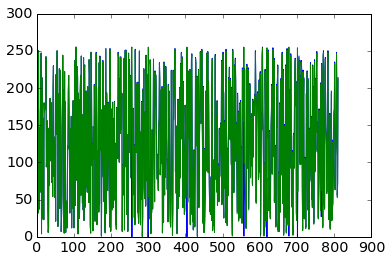

In [183]:
plot(lidx_decode)
plot(lidx)


figures/outerproduct_capacity-Nx=320-Mx811-D256-170131.npz


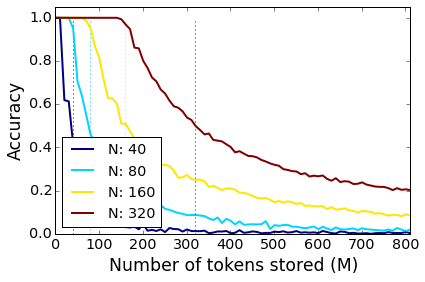

In [196]:
iD = 2

cols = get_cmap('jet', len(test_N))

for iN, N in enumerate(test_N):
    plot(test_M, num_correct[:, iN, iD] / test_M, c=cols(iN), lw=2, label="N: " + str(N))
    #plot(test_M, p_correct_l(test_M, N=2.2*test_N[iN]**1.4, D=test_D[iD]), c=cols(iN))
    plot([N, N], [0, 1], ':', c=cols(iN))
    
ylim([0,1.05])
xlim([0, test_M.max()])
legend(loc='lower left')

xlabel('Number of tokens stored (M)')
ylabel('Accuracy')

plt.tight_layout()

filename = ('figures/outerproduct_capacity-Nx=' + str(test_N.max())
            + '-Mx' + str(test_M.max())
            + '-D' + str(test_D[iD])
            + '-' + time.strftime('%y%m%d') +'.npz')
print filename

savefig(filename + '.eps', format='eps', transparent=True)
savefig(filename + '.png', format='png', transparent=True)



figures/outerproduct_capacity-N=40-Mx811-Dx256-170131.npz


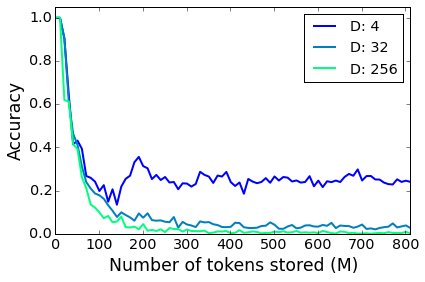

In [197]:
iN = 0
cols = get_cmap('winter', len(test_D))

for iD, D in enumerate(test_D):
    plot(test_M, num_correct[:, iN, iD] / test_M, c=cols(iD), lw=2, label="D: " + str(D))
    #plot(test_M, p_correct_l(test_M, N=2*test_N[iN]**1.5, D=test_D[iD]), c=cols(iD))
    
ylim([0,1.05])
xlim([0, test_M.max()])

xlabel('Number of tokens stored (M)')
ylabel('Accuracy')
legend()

plt.tight_layout()

filename = ('figures/outerproduct_capacity-N=' + str(test_N[iN])
            + '-Mx' + str(test_M.max())
            + '-Dx' + str(test_D.max())
            + '-' + time.strftime('%y%m%d') +'.npz')
print filename

savefig(filename + '.eps', format='eps', transparent=True)
savefig(filename + '.png', format='png', transparent=True)



figures/outerproduct_capacity-perN-Nx=320-Mx811-D32-170131.npz


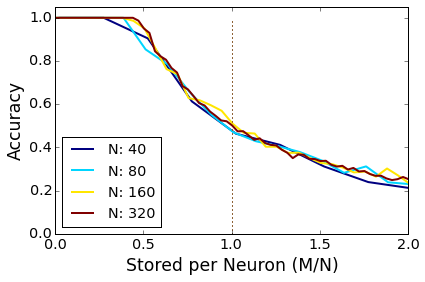

In [201]:
iD = 1

cols = get_cmap('jet', len(test_N))

for iN, N in enumerate(test_N):
    plot(test_M/N, num_correct[:, iN, iD] / test_M, c=cols(iN), lw=2, label="N: " + str(N))
    #plot(test_M, p_correct_l(test_M, N=2.2*test_N[iN]**1.4, D=test_D[iD]), c=cols(iN))
    plot([N, N]/N, [0, 1], ':', c=cols(iN))
    
ylim([0,1.05])
xlim([0, 2])
legend(loc='lower left')

xlabel('Stored per Neuron (M/N)')
ylabel('Accuracy')

plt.tight_layout()

filename = ('figures/outerproduct_capacity-perN-Nx=' + str(test_N.max())
            + '-Mx' + str(test_M.max())
            + '-D' + str(test_D[iD])
            + '-' + time.strftime('%y%m%d') +'.npz')
print filename

savefig(filename + '.eps', format='eps', transparent=True)
savefig(filename + '.png', format='png', transparent=True)



In [127]:
iN = -1
iD = -1

cols = get_cmap('spring', len(test_K))

for iK, K in enumerate(test_K):
    plot(test_M, num_correct[:, iN, iD, iK] / test_M, c=cols(iK), lw=2)
    plot(test_M, p_correct_l(test_M, N=0.05*test_N[iN]**2, D=test_D[iD]), c=cols(iK))
    
ylim([0,1.05])

xlabel('Number of tokens stored (M)')
ylabel('Accuracy')

IndexError: too many indices for array

In [33]:
def test_capacity_sparsity_outercorr(rt2N, D, K=5, sf=0.1, trials=5e3):
    '''
    Runs a capacity experiment with sparsity in the basis vectors
    '''
    N =  rt2N**2
    lv = 2 * (np.random.randn(D, rt2N) > 0) - 1
    letter_vectors = np.zeros((D,N))
    
    for d in range(D):
        letter_vectors[d, :] = np.outer(lv[d, :], lv[d, :]).flatten()
        
        
    # sparsity is just replacing +1/-1 with zero randomly
    make_sparse = np.random.rand(D,N) < sf
    
    letter_vectors[make_sparse] = 0
    
    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)
    
    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)
        
        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [34]:
lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_sparsity_outercorr(20, 32)


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-pac

Duration:  0.327313899994


In [358]:
plot(smooth(lidx==lidx_li, 5))

NameError: name 'smooth' is not defined

In [13]:
# visualizing stuff as images
def vec2im(vec):
    
    vecl = len(vec)
    vec_div = int(vecl ** 0.5)
    
    for i in range(vec_div):
        if mod(vecl, vec_div) == 0:
            break
        else:
            vec_div -= 1
            
    return norm_range(vec.reshape((vec_div, vecl/vec_div)))

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


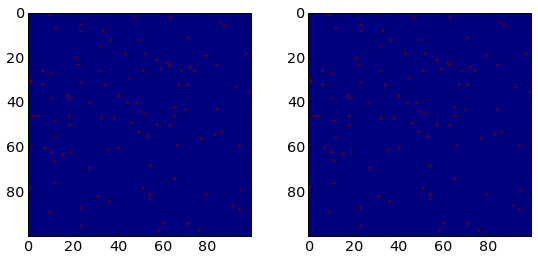

In [52]:
init_vector = letter_vectors[0, :].copy()

#init_vector += letter_vectors[1,:]

#prob0 = 0.4
#make0 = np.random.rand(N) < prob0
#init_vector[make0] = 0

figure(figsize=(10,4))

subplot(121)
imshow(vec2im(letter_vectors[0,:]))
subplot(122)
imshow(vec2im(init_vector))

In [57]:
nsteps = 16
noise = 1

hopvec = init_vector.copy() + noise * np.random.randn(N)
hop_history = np.zeros((nsteps, N))
hopvec = 1.0 * (hopvec > Ks/N)

for i in range(nsteps):
    hop_history[i, :] = hopvec
    
    hopvec = np.dot(hop_matrix, hopvec)
    # heaviside function
    hopvec = 1.0* ( hopvec > Ks)
    


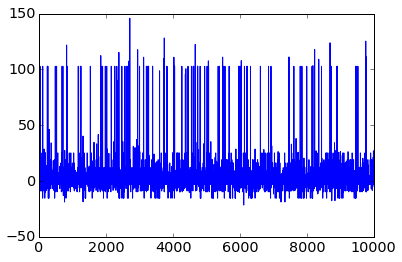

In [62]:
hopvec = init_vector.copy() + noise * np.random.randn(N)

hopvect = np.dot(hop_matrix, hopvec)
plot(hopvect - hopvect.mean());


In [58]:
hopvec = init_vector.copy()
hv = 1.0 * (hopvec > Ks)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


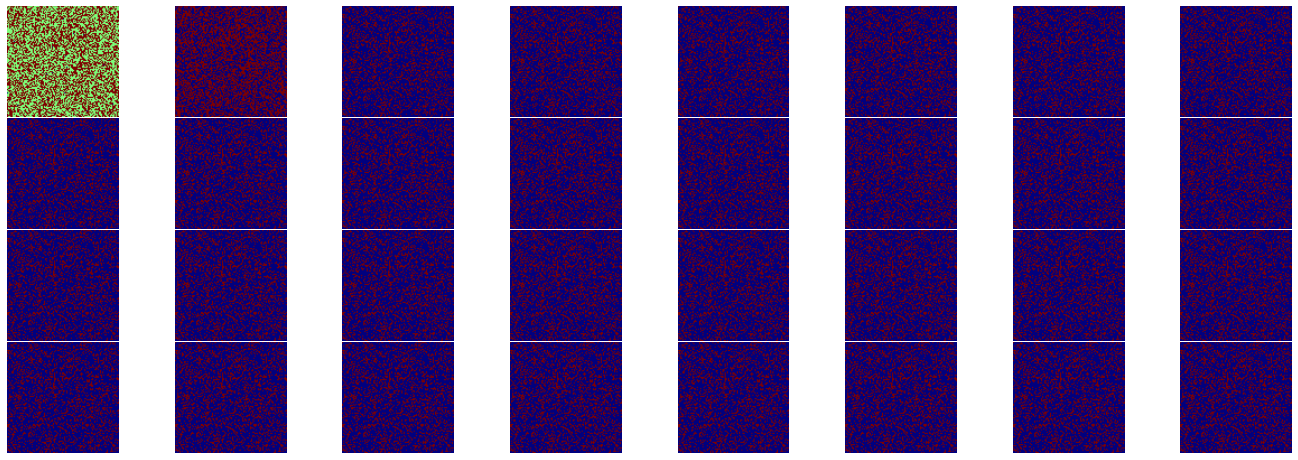

In [59]:
plt.rcParams['figure.subplot.hspace'] = 0.01
plt.rcParams['figure.subplot.wspace'] = 0.01

figure(figsize=(24,8))

nrows = 4


for i in range(min(90, nsteps)):
    ax=subplot(nrows, 2*nsteps//nrows, 2*i+1)
    imshow(vec2im(hop_history[i,:] - letter_vectors[0,:]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
    ax=subplot(nrows, 2*(nsteps//nrows), 2*i+2)
    imshow(vec2im(hop_history[i,:]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


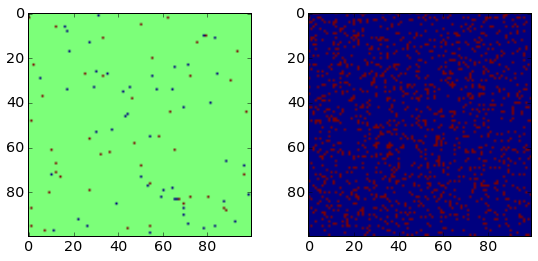

In [29]:
init_vector = letter_vectors[0, :].copy()

#init_vector += letter_vectors[1,:]

#prob0 = 0.4
#make0 = np.random.rand(N) < prob0
#init_vector[make0] = 0

figure(figsize=(10,4))

subplot(121)
imshow(vec2im(letter_vectors[0,:]))
subplot(122)
imshow(vec2im(hopvec))

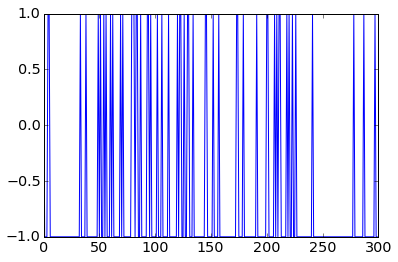

In [32]:
plot(hopvec[200:500])